# Aşağıda bazı değişkenlerin açıklaması verilmiştir:

- **MRR**: Müşterinin E-corp’a aylık olarak ödediği para miktarını gösterir.
- **Total Revenue: Müşterinin**: E-corp ürünlerini kullanarak elde ettiği toplam gelir miktarını gösterir.
- **Help Ticket Count: Müşterinin**: müşteri destek ekibinden yardım almak için oluşturduğu toplam talep sayısını gösterir.
- **Help Ticket Lead Time(hours)**: İlgili müşteri tarafından oluşturulan taleplerin ortalama çözüm süresini gösterir.
- **Company Newsletter Interaction Count**: Müşterinin, E-corp tarafından gönderilen bültenlerle kaç kez etkileşime geçtiğini gösterir.
- **Status**: Müşterinin satış sürecindeki mevcut durumunu gösterir.

# Gerekli Kütüphaneler


In [ ]:
# Gerekli kütüphaneler.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.options.display.float_format = '{:,.2f}'.format

# Veri Okuma

In [ ]:
CSAT_Survey = pd.read_csv("CSAT_Survey_Data.csv")
Customer_Age= pd.read_csv("Customer_Age_Data.csv")
Customer_MRR = pd.read_csv("Customer_MRR_Data.csv")
Customer_Revenue= pd.read_csv("Customer_Revenue_Data.csv")
Help_Ticket=pd.read_csv("Help_Ticket_Data.csv")
Newsletter_Interaction = pd.read_csv("Newsletter_Interaction_Data.csv")
Product_Bug_Task = pd.read_csv("Product_Bug_Task_Data.csv")
RegionAndVertical = pd.read_csv("RegionAndVertical_Data.csv")
StatusAndLevel = pd.read_csv("StatusAndLevel_Data.csv")

# Veriye İlk Bakış

In [3]:
def check_df(dataframe, head=5):
    
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    try:
        print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    except TypeError:
        print("Bu bir Type hatasidir.")

In [4]:
check_df(Customer_Revenue)

##################### Shape #####################
(901, 2)
##################### Types #####################
Customer ID      object
Total Revenue    object
dtype: object
##################### Head #####################
   Customer ID Total Revenue
0  CRM-1470950      $732,199
1  CRM-1526100            $0
2  CRM-1506400      $375,135
3  CRM-1430550            $0
4  CRM-1485600      $116,732
##################### Tail #####################
     Customer ID Total Revenue
896   CRM-783450       $16,527
897  CRM-1500500            $0
898   CRM-155450      $567,026
899  CRM-1499600   $15,967,518
900  CRM-1451550       $30,478
##################### NA #####################
Customer ID      0
Total Revenue    0
dtype: int64
##################### Quantiles #####################
Bu bir Type hatasidir.


# Veri Ön işleme

In [5]:
# Veriler birleştirildi ve ID yeniden düzenlendi.

list_of_data = [Customer_MRR, Customer_Revenue, Help_Ticket, Newsletter_Interaction, StatusAndLevel,RegionAndVertical]

for i in list_of_data:

        i["Customer ID"] = i["Customer ID"].str.replace('CRM-', '', regex=True)
        i.rename(columns={"Customer ID": "ID"}, inplace=True)

merged_df = list_of_data[0]
for df in list_of_data[1:]:
    merged_df = pd.merge(merged_df, df, on='ID', how='outer')


In [6]:
check_df(merged_df)

##################### Shape #####################
(2715, 11)
##################### Types #####################
ID                                       object
MRR                                      object
Total Revenue                            object
Help Ticket Count                       float64
Help Ticket Lead Time (hours)           float64
Company Newsletter Interaction Count    float64
Status                                   object
Customer Level                           object
Region                                   object
Vertical                                 object
Subvertical                              object
dtype: object
##################### Head #####################
        ID      MRR Total Revenue  Help Ticket Count  Help Ticket Lead Time (hours)  Company Newsletter Interaction Count    Status   Customer Level     Region Vertical           Subvertical
0  1002400   $6,716      $279,868              55.00                         701.00                        

In [7]:
# Dolar($) işaretleri silindi.

Clean_dolar_sign = ["MRR","Total Revenue"]  

for col in Clean_dolar_sign:

    merged_df[col]=merged_df[col].astype(str).str.replace("$","")
    merged_df[col]=merged_df[col].astype(str).str.replace(",","")

### Nan değerler bir el atma

Veride Nan ifadesinin yerine nan var. Bunda değişiklik yapıldı ayrıca `MRR` ile `Total Revenue` ortak olan Nan 0 ile dolduruldu ve `Help Ticket Count` ile `Help Ticket Lead Time (hours)` ortak olan Nan değrler 0 ile dolduruldu. `Company Newsletter Interaction Count` column çok fazla Nan değerler bulunduğundan ötürü uçuruldu ,categorik değişkenler ise mod ile dolduruldu.
#### **`ÖNEMLİ!`**

Nan değerler `KKNNImputer` algroitaması ile tahmin yapıldığında Standart sapması çok yüksek olup bu da verinin tarafsızlığını bozdu. 

In [8]:
# Nan değeer ilk bakış

merged_df.isnull().sum().sort_values(ascending=False)

Company Newsletter Interaction Count    2464
Help Ticket Count                       1348
Help Ticket Lead Time (hours)           1348
Subvertical                              166
Vertical                                 130
Customer Level                            49
Region                                    49
Status                                    48
ID                                        16
MRR                                        0
Total Revenue                              0
dtype: int64

In [9]:
merged_df["MRR"]=merged_df["MRR"].str.replace('nan','NaN')
merged_df["Total Revenue"]=merged_df["Total Revenue"].str.replace('nan','NaN')

merged_df["Total Revenue"]=merged_df["Total Revenue"].astype(float)
merged_df["MRR"]=merged_df["MRR"].astype(float)

merged_df.drop("Company Newsletter Interaction Count",axis=1,inplace=True)
merged_df[["MRR", "Total Revenue"]] = merged_df[["MRR", "Total Revenue"]].fillna(0)
merged_df[["Help Ticket Count","Help Ticket Lead Time (hours)"]] = merged_df[["Help Ticket Count","Help Ticket Lead Time (hours)"]].fillna(0)

fill_mode_cols = ["Subvertical", "Vertical", "Customer Level", "Region", "Status"]

for col in fill_mode_cols:
    merged_df[col].fillna(merged_df[col].mode()[0], inplace=True)

merged_df.dropna(subset=["ID"],axis=0,how='any',inplace=True)

In [10]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
MRR,"2,699.00","2,011.31","4,255.94",0.00,0.00,196.00,"2,500.00","62,732.00"
Total Revenue,"2,699.00","4,203,244.95","70,648,827.91",0.00,0.00,0.00,582.00,"2,789,805,441.00"
Help Ticket Count,"2,699.00",8.81,20.03,0.00,0.00,1.00,9.00,443.00
Help Ticket Lead Time (hours),"2,699.00",398.25,619.53,0.00,0.00,62.00,606.00,"11,632.00"


# Keşifçi Veri Analizi(EDA)

### Kategorik Değişken Analizi

In [11]:
# Bu fonksiyon Kategorik Değişkenleri dağılımını incelemek için

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        plt.title(col_name + " Tüm Verideki Dağilimi")
        fig = plt.gcf()
        fig.set_size_inches(20,7)
        sns.countplot(y=dataframe[col_name], data=dataframe)
        plt.show(block=True)

                Region  Ratio
Region                       
Turkey             716  26.53
MENA               237   8.78
CEE                228   8.45
Taiwan             151   5.59
Vietnam            151   5.59
Australia          149   5.52
Indonesia          143   5.30
United Kingdom     110   4.08
Russia             100   3.71
Malaysia            88   3.26
Singapore           81   3.00
Benelux             75   2.78
Korea               74   2.74
Brazil              71   2.63
Thailand            65   2.41
France              61   2.26
Japan               42   1.56
Spain               40   1.48
South Cone          34   1.26
United States       34   1.26
Hong Kong           23   0.85
Philippines         19   0.70
Mexico               7   0.26
##########################################


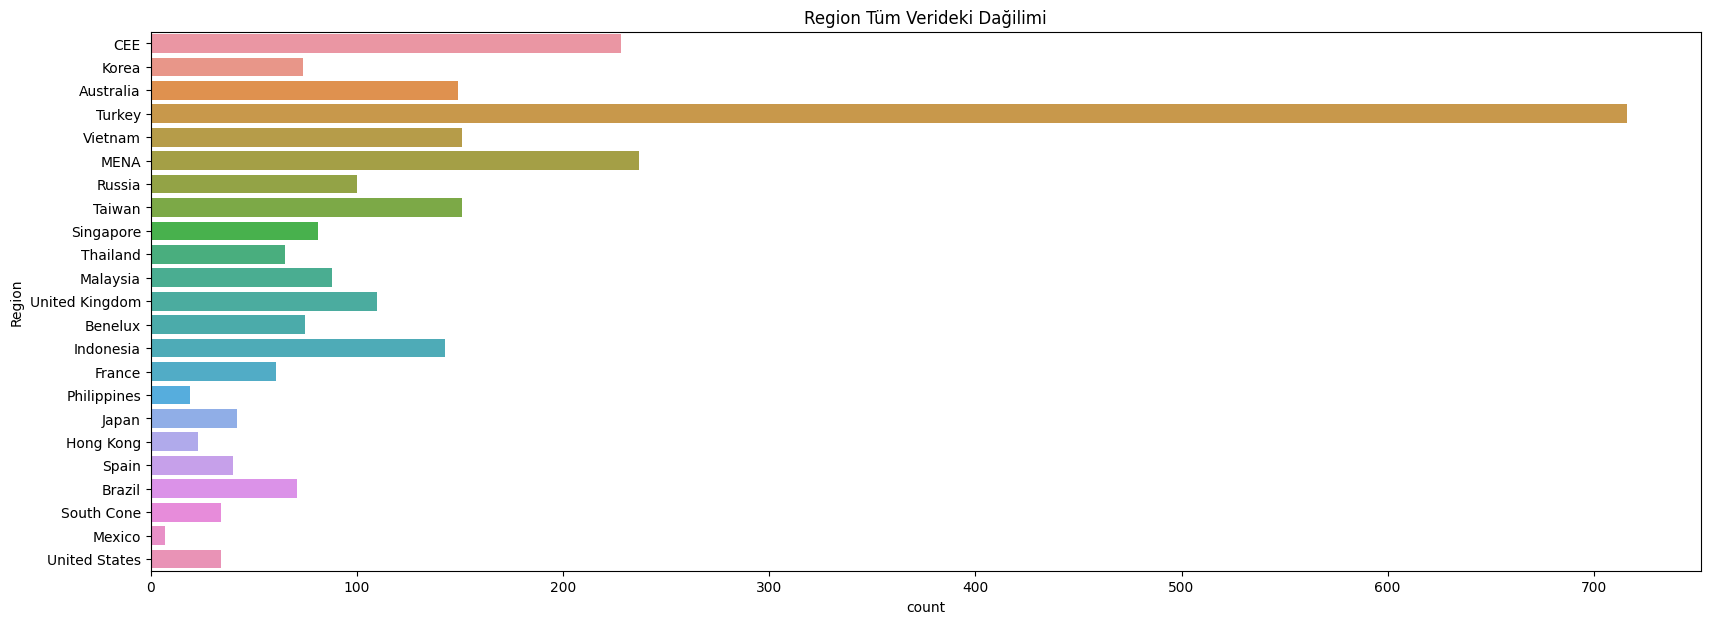

In [12]:
cat_summary(merged_df,"Region",plot=True)

                 Customer Level  Ratio
Customer Level                        
Enterprise                 1122  41.57
Long-tail                  1003  37.16
Semi-Enterprise             574  21.27
##########################################


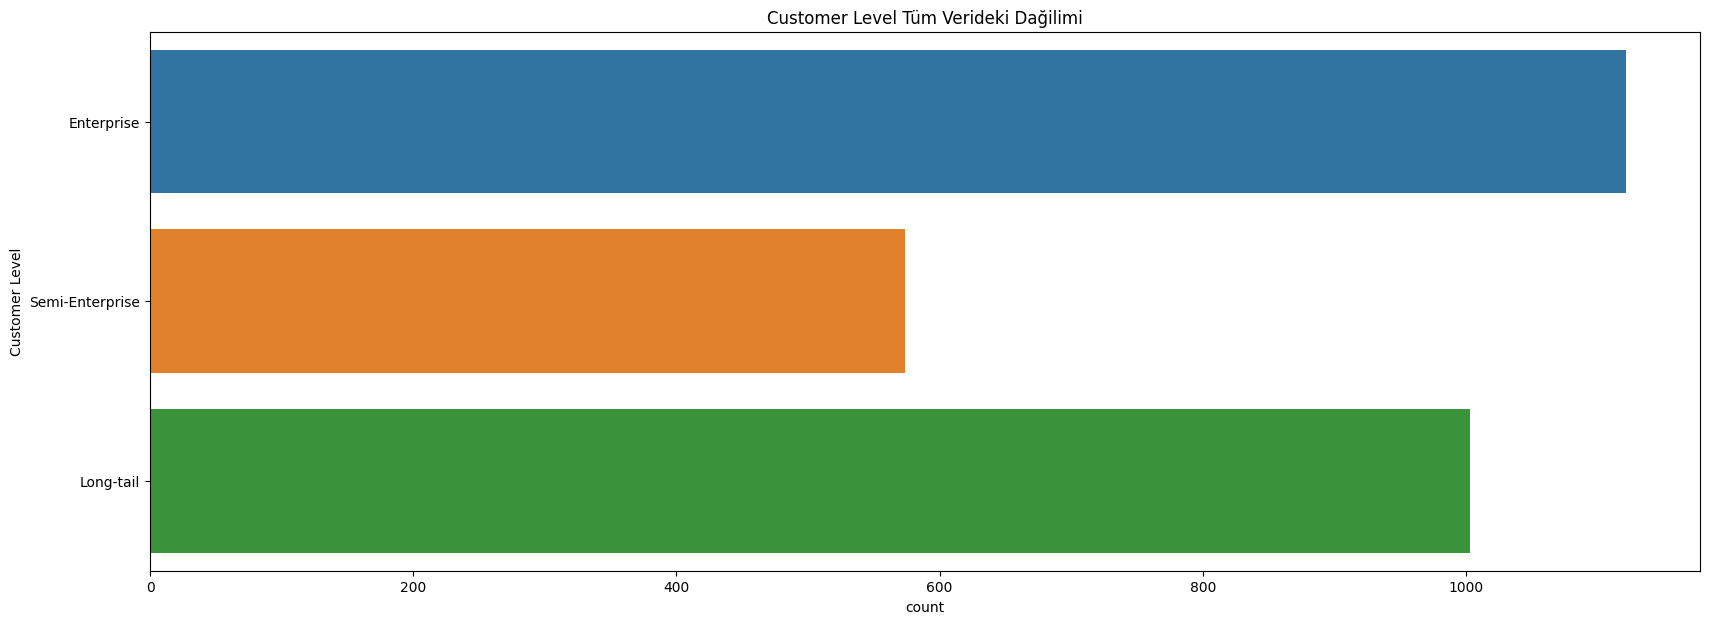

In [13]:
cat_summary(merged_df,"Customer Level",plot=True)

                              Vertical  Ratio
Vertical                                     
Retail                            1624  60.17
Finance                            160   5.93
Other                              132   4.89
Travel                             131   4.85
Automotive                         113   4.19
Media and Publishing               105   3.89
Restaurants and Delivery            99   3.67
Healthcare                          61   2.26
Internet and Telecom                59   2.19
Career and Education                46   1.70
B2B Commerce                        38   1.41
Real Estate                         36   1.33
Classifieds                         24   0.89
Transportation and Logistics        21   0.78
Financial Services                   9   0.33
Ebetting and Lottery                 8   0.30
Non Profit Organizations             7   0.26
B2B SaaS                             7   0.26
Gaming                               6   0.22
Consumer Electronics              

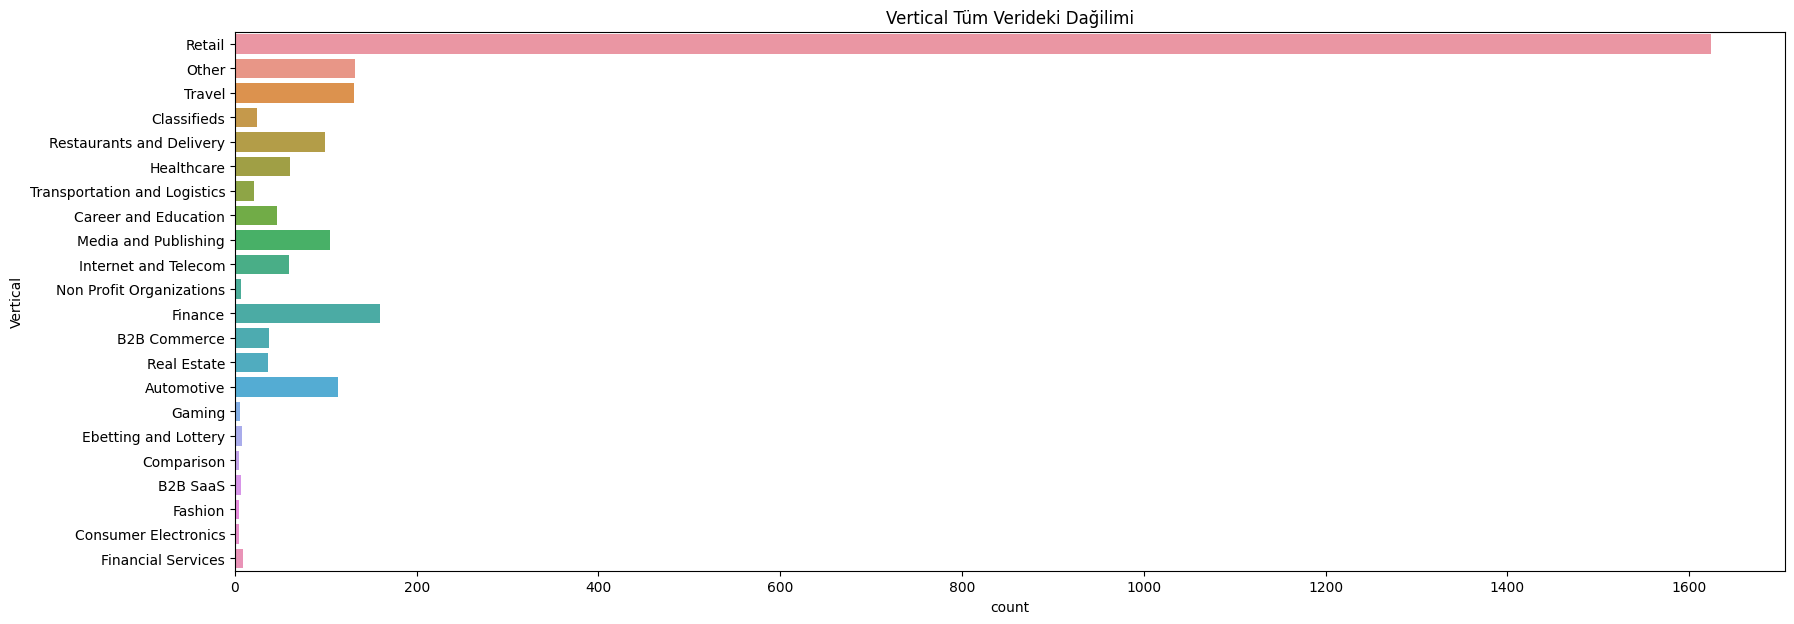

In [14]:
cat_summary(merged_df,"Vertical",plot=True)

                         Status  Ratio
Status                                
Churn                      1263  46.80
Retained                   1050  38.90
Onboarding                  320  11.86
Incomplete Deal              31   1.15
Contract Confirmation        21   0.78
In Opportunity Pipeline      12   0.44
PoC                           2   0.07
##########################################


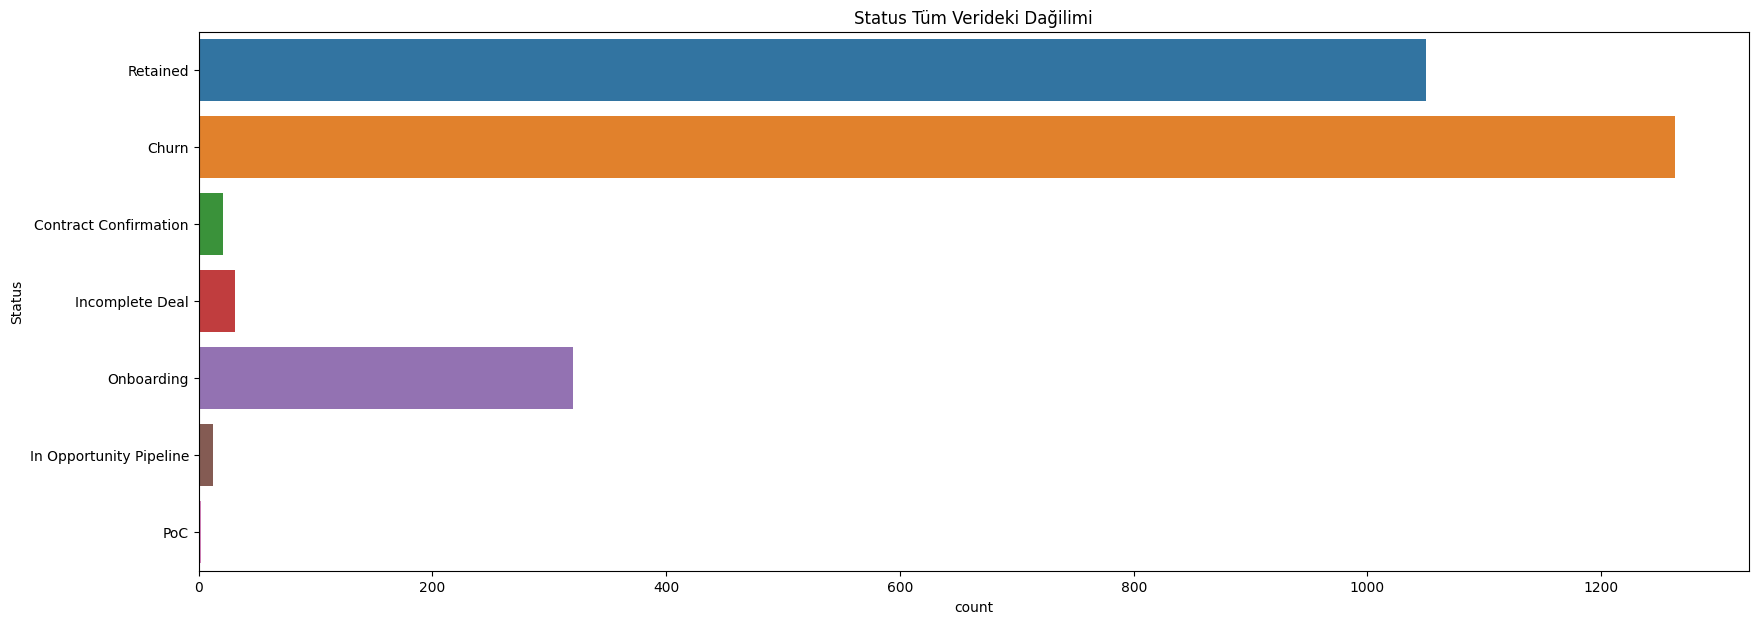

In [15]:
cat_summary(merged_df,"Status",plot=True)

`Retained`: En yüksek `MRR` ve `Total Revenue` en yüksek toplam geliri müşteri segmenti(En değerli segment). Ancak yüksek destek talepleri ve uzun çözüm süreleri var. Otomasyon & self-service destek seçenekleriyle yükü azaltılabilir.

`Churn`: Churn olan müşteriler hiçbir gelir sağlamıyor ancak destek talepleri var.

`Onboarding`: Yüksek gelir potansiyeli var. Ancak uzun destek çözüm süresi (303.64 saat) müşteri memnuniyetini olumsuz etkileyebilir.Daha hızlı Onboarding süreci oluşturabilir. Ayrıca yeni müşteriler için özel destek ekibi oluşturun.

`Incomplete Deal`: Burası ise potansiyel kayıp alanı, zaten anlaşmalar tamamlanmadığında gelir çok düşük kalıyor. Çözüm olarak satış sürecini daha şeffaf hale getirerek müşteri güvenini artırın ve daha hızlı yanıt süresi sağlayarak anlaşmaları tamamlamaya odaklanabilir.

`Contract Confirmation`: Düşük destek yükü ve kısa bekleme süresi ile bu süreci tamamen otomatikleştirerek daha da hızlandırabilinir.

`In Opportunity Pipeline`: Fırsat Aşamasındaki Müşteriler. Bunlar satışa dönüşmeyen ancak ilgi gösteren müşteri grup. Destek süreleri görece uzun gözüküyor, bu da satış sürecini olumsuz etkileyebilir onun için satış öncesi destek ekibini güçlendirerek olası müşteri kayıplarını önlenebilir.

`PoC`: Hiç bir etkinlik yok.

In [16]:
merged_df.groupby("Status")[["MRR","Total Revenue","Help Ticket Count","Help Ticket Lead Time (hours)"]].\
    agg({"mean","sum"}).\
    sort_values(("Help Ticket Count","sum"),ascending=False)

MRR              Total Revenue                   Help Ticket Count           Help Ticket Lead Time (hours)           
                            mean          sum          mean               sum              mean       sum                          mean        sum
Status                                                                                                                                            
Retained                4,034.46 4,236,187.00 10,804,341.06 11,344,558,116.00             17.76 18,648.00                        600.67 630,703.00
Churn                     296.48   374,456.00          0.00              0.00              3.06  3,861.00                        264.44 333,987.00
Onboarding              2,522.69   807,260.00          0.00              0.00              3.79  1,214.00                        303.64  97,166.00
Incomplete Deal            85.48     2,650.00          0.00              0.00              1.26     39.00                        320.16   9,925.00
Contract Confirmation     379.29     7,965.00          0.00              0.00              0.57     12.00                         73.38   1,541.00
In Opportunity Pipeline     0.00         0.00          0.00              0.00              0.75      9.00                        129.50   1,554.00
PoC                         0.00         0.00          0.00              0.00              0.00      0.00                          0.00       0.00

`Enterprise`: Bu müşteriler, ortalama MRR ve toplam gelir açısından en büyük katkıyı sağlıyor. Enterprise müşterileri en fazla destek talebi oluşturuyor (16,048 adet) ve ortalama çözüm süresi en uzun (491.13 saat). Enterprise müşterilerinin öncelikli destek alması sağlanabilmeli. Çünkü en büyük gelir kaynağı bu segment.

`Semi-Enterprise`: Enterprise'a kıyasla düşük MRR'ye sahip ancak toplam gelirleri belirli bir seviyede. Semi-Enterprise müşterilerinin destek talepleri daha az ve çözüm süreleri biraz daha kısa (455.82 saat).

`Long-tail`: Toplam müşteri sayısı fazla olmasına rağmen en düşük MRR'ye sahip. Ancak toplam gelir açısından Semi-Enterprise müşterileriyle yarışıyor. Bu da büyük sayıda küçük müşteri segmentinin önemli bir gelir kaynağı olduğunu gösteriyor. Ama Long-tail müşterilerinin destek talepleri çok düşük (2,647 adet) ancak ortalama bekleme süresi daha kısa (261.41 saat).

In [17]:
merged_df.groupby("Customer Level")[["MRR","Total Revenue","Help Ticket Count","Help Ticket Lead Time (hours)"]].\
    agg({"mean","sum"}).\
    sort_values(("Help Ticket Count","sum"),ascending=False)

MRR              Total Revenue                  Help Ticket Count           Help Ticket Lead Time (hours)           
                    mean          sum          mean              sum              mean       sum                          mean        sum
Customer Level                                                                                                                           
Enterprise      3,969.31 4,453,570.00  8,338,098.22 9,355,346,206.00             14.30 16,048.00                        491.13 551,048.00
Semi-Enterprise 1,226.16   703,814.00  1,547,953.10   888,525,080.00              8.86  5,088.00                        455.82 261,638.00
Long-tail         270.32   271,134.00  1,097,394.65 1,100,686,830.00              2.64  2,647.00                        261.41 262,190.00

`Fashion`: Bu sektör en yüksek ortalama MRR'ye sahip (6,456.50), ancak toplam geliri düşük. Büyük müşteri segmentleriyle gelir artırılabilinir.

`Retail`: Bu sektör ise, toplam gelir açısından en büyük sektör (7.7 milyar dolar). Ancak, MRR seviyesi orta düzeyde. Bu, müşteri sadakatinin artırılmasıyla gelir büyütme potansiyeli olduğunu gösterebilir.

`Finance`: toplam geliri oldukça düşük. Bunun nedeni, sınırlı müşteri tabanı olabilir.

In [18]:
merged_df.groupby("Vertical")[["MRR","Total Revenue","Help Ticket Count","Help Ticket Lead Time (hours)"]].\
    agg({"mean","sum"}).\
    sort_values(("Help Ticket Count","sum"),ascending=False)

MRR              Total Revenue                  Help Ticket Count           Help Ticket Lead Time (hours)           
                                 mean          sum          mean              sum              mean       sum                          mean        sum
Vertical                                                                                                                                              
Retail                       2,070.99 3,363,280.00  4,745,324.06 7,706,406,273.00             10.21 16,584.00                        423.55 687,840.00
Travel                       2,277.25   298,320.00 26,018,645.19 3,408,442,520.00             12.69  1,663.00                        304.85  39,936.00
Finance                      2,333.85   373,416.00        681.67       109,068.00              5.22    836.00                        323.62  51,779.00
Automotive                   1,560.01   176,281.00    568,777.92    64,271,905.00              6.42    726.00                        483.30  54,613.00
Internet and Telecom         5,405.36   318,916.00    207,255.17    12,228,055.00             10.86    641.00                        604.54  35,668.00
Restaurants and Delivery     1,559.92   154,432.00    305,139.84    30,208,844.00              6.23    617.00                        405.04  40,099.00
Media and Publishing           919.45    96,542.00     26,391.50     2,771,107.00              4.72    496.00                        385.98  40,528.00
B2B Commerce                 1,106.79    42,058.00    211,788.18     8,047,951.00             11.29    429.00                        351.13  13,343.00
Other                        1,293.89   170,794.00     57,422.78     7,579,807.00              3.01    397.00                        256.05  33,798.00
Career and Education         1,370.74    63,054.00          0.00             0.00              6.17    284.00                        350.98  16,145.00
Healthcare                   1,282.26    78,218.00    752,129.92    45,879,925.00              4.43    270.00                        295.70  18,038.00
Real Estate                  2,265.58    81,561.00          0.00             0.00              7.28    262.00                        207.03   7,453.00
Classifieds                  2,501.00    60,024.00  2,082,444.00    49,978,656.00              6.38    153.00                        556.33  13,352.00
Gaming                       1,954.33    11,726.00  1,177,808.50     7,066,851.00             17.33    104.00                        401.50   2,409.00
Financial Services           3,266.33    29,397.00          0.00             0.00              9.89     89.00                        295.22   2,657.00
Transportation and Logistics 1,615.76    33,931.00      8,134.81       170,831.00              3.38     71.00                        296.33   6,223.00
Consumer Electronics         4,622.00    23,110.00     86,578.20       432,891.00             12.60     63.00                        312.80   1,564.00
Fashion                      6,456.50    25,826.00    240,724.50       962,898.00             14.25     57.00                        405.50   1,622.00
Ebetting and Lottery         1,906.88    15,255.00         63.12           505.00              1.75     14.00                        231.88   1,855.00
Non Profit Organizations       922.71     6,459.00          0.00             0.00              1.43     10.00                        614.29   4,300.00
B2B SaaS                       551.00     3,857.00          4.14            29.00              1.29      9.00                        222.71   1,559.00
Comparison                     515.25     2,061.00          0.00             0.00              2.00      8.00                         23.75      95.00

En uzun ortalama çözüm süresine sahip sektörler: Airlines and Airports (43.89 saat) ve Consumer Electronics (11.89 saat) gibi sektörler, bu uzun saatler yukarda da bahsedildiği gibi hizmet kalitesini etkileyebilir. En kısa çözüm süresine sahip sektörler genellikle düşük yardım bilet sayısı olanlardır. Yüksek MRR ve toplam gelir, genellikle karmaşık hizmet taleplerine ve yüksek müşteri ihtiyacına işaret eder. Örneğin, havayolları genellikle karmaşık rezervasyon ve müşteri destek süreçlerine sahiptir. Düşük MRR ve düşük toplam gelir, hizmet taleplerinin daha basit veya tüketiciye doğrudan ürün sunan sektörlerde yoğunlaştığını gösterir.

**Yapılması gereken:**
- Yüksek müşteri talepleriyle başa çıkabilmek için iş akışlarının ve müşteri destek süreçlerinin iyileştirilmesi önemlidir.
- Düşük MRR ve toplam gelir sağlayan sektörlerde ise, pazarlama stratejisini gözden geçirmek ve ürün sunumunu geliştirmek gerekebilir.


In [19]:
merged_df.groupby("Subvertical")[["MRR","Total Revenue","Help Ticket Count","Help Ticket Lead Time (hours)"]].\
    agg({"mean","sum"}).\
    sort_values(("Help Ticket Count","sum"),ascending=False)

MRR              Total Revenue                  Help Ticket Count          Help Ticket Lead Time (hours)           
                                 mean          sum          mean              sum              mean      sum                          mean        sum
Subvertical                                                                                                                                          
Fashion Retailer             2,168.79 1,208,018.00    660,377.78   367,830,426.00              9.11 5,072.00                        356.84 198,758.00
Cosmetics                    1,998.35   523,568.00  1,039,019.88   272,223,209.00              9.57 2,507.00                        515.32 135,014.00
Consumer Electronics         2,167.57   364,151.00  8,895,493.27 1,494,442,869.00             11.89 1,997.00                        428.57  72,000.00
Home and Furniture           2,690.54   352,461.00 11,548,930.69 1,512,909,920.00             13.88 1,818.00                        437.89  57,363.00
Airlines and Airports        8,311.04   232,709.00 88,323,851.86 2,473,067,852.00             43.89 1,229.00                        446.68  12,507.00
Sports                       1,886.77   162,262.00    589,619.36    50,707,265.00             11.35   976.00                        639.87  55,029.00
Marketplace                  3,375.53   293,671.00 36,003,287.56 3,132,286,018.00             10.40   905.00                        437.28  38,043.00
Automotive                   1,518.52   174,630.00    557,193.79    64,077,286.00              6.39   735.00                        471.39  54,210.00
Restaurants and Delivery     1,552.62   159,920.00    299,090.70    30,806,342.00              7.09   730.00                        416.25  42,874.00
Internet and Telecom         5,826.22   314,616.00    213,058.35    11,505,151.00             11.00   594.00                        620.96  33,532.00
Banking                      4,017.05   241,023.00          0.00             0.00              7.88   473.00                        435.30  26,118.00
Supermarket Chains           1,971.20    98,560.00    181,706.04     9,085,302.00              9.04   452.00                        468.54  23,427.00
Shoes                          969.18    43,613.00     38,972.56     1,753,765.00              9.69   436.00                        282.84  12,728.00
Other                        1,210.56   148,899.00     65,526.53     8,059,763.00              3.54   435.00                        228.02  28,047.00
Jewelry and Accessories        810.29    41,325.00     62,617.65     3,193,500.00              8.39   428.00                        286.78  14,626.00
B2B Commerce                 1,201.66    42,058.00    229,941.46     8,047,951.00             12.09   423.00                        357.77  12,522.00
Book Retailers               1,720.11    30,962.00 41,161,167.89   740,901,022.00             21.28   383.00                        608.17  10,947.00
Home Appliances              1,563.13    73,467.00  1,807,971.85    84,974,677.00              7.00   329.00                        495.45  23,286.00
Animal Products              3,069.93    89,028.00    737,847.31    21,397,572.00              9.90   287.00                        381.03  11,050.00
Insurance                    1,522.77    53,297.00          0.00             0.00              8.11   284.00                        422.83  14,799.00
Kids Fashion                   558.71    11,733.00     88,219.05     1,852,600.00             13.52   284.00                        497.71  10,452.00
Education and Universities   1,487.65    55,043.00          0.00             0.00              7.59   281.00                        423.27  15,661.00
Content Websites             1,042.47    79,228.00        291.55        22,158.00              3.66   278.00                        356.80  27,117.00
Real Estate                  2,330.31    81,561.00          0.00             0.00              7.49   262.00                        21

`MENA`(Orta Doğu ve Kuzey Afrika bölgesi): Bu bölge toplam gelirde en önde, bu durum yüksek hizmet talebi veya geniş müşteri tabanıyla ilişkili olabilir.`Brazil` yüksek MRR ve toplam gelir açısından da güçlü biri performansa sahipken, `Turkey` yüksek yardım bilet sayısıyla dikkat çekiyor; bu, müşteri desteği gereksinimlerinin arttığını gösteriyor.


Genel olarak, yüksek yardım bilet sayısına sahip bölgeler (ör. `Türkiye`) daha yüksek yanıt sürelerine sahip olabilir, bu da yoğun çalışma gereksinimini işaret eder.`Hong Kong` gibi bölgelerdeki uzun yanıt süreleri, yoğun iş yükü veya kaynak sınırlamaları nedeniyle olabilir.


aşağıdaki veriden her bir bölgenin operasyonel verimliliği, müşteri talebi ve potansiyel büyüme alanları hakkında önemli bilgiler sunduğunu. Ve performansı artırmak için, pazarlama stratejilerinin güncellenmesi ve hizmet sunumunun çeşitlendirilmesi üzerinde durulabilinir.

In [20]:
merged_df.groupby("Region")[["MRR","Total Revenue","Help Ticket Count","Help Ticket Lead Time (hours)"]].\
    agg({"mean","sum"}).\
    sort_values(("Help Ticket Count","sum"),ascending=False)

MRR            Total Revenue                  Help Ticket Count          Help Ticket Lead Time (hours)           
                   mean        sum          mean              sum              mean      sum                          mean        sum
Region                                                                                                                               
Turkey           964.35 690,477.00    957,953.20   685,894,494.00              8.64 6,186.00                        427.75 306,268.00
MENA           1,840.68 436,241.00 18,258,957.43 4,327,372,912.00             10.16 2,407.00                        445.68 105,626.00
Australia      4,124.07 614,486.00  5,636,980.60   839,910,109.00             14.05 2,094.00                        389.36  58,014.00
CEE            1,313.35 299,444.00  1,188,827.46   271,052,661.00              8.30 1,893.00                        524.35 119,551.00
Taiwan         2,822.10 426,137.00  1,084,025.77   163,687,891.00              9.76 1,474.00                        420.79  63,540.00
Singapore      2,575.52 208,617.00 10,845,983.77   878,524,685.00             17.46 1,414.00                        541.95  43,898.00
Malaysia       2,139.64 188,288.00    195,492.24    17,203,317.00             11.51 1,013.00                        575.93  50,682.00
Thailand       2,789.48 181,316.00    373,905.46    24,303,855.00             14.08   915.00                        377.34  24,527.00
Benelux        2,896.13 217,210.00    457,044.45    34,278,334.00             11.51   863.00                        410.59  30,794.00
Vietnam        2,556.08 385,968.00 10,919,144.03 1,648,790,748.00              5.29   799.00                        251.68  38,004.00
Brazil         5,837.37 414,453.00  1,783,060.08   126,597,266.00             10.80   767.00                        435.20  30,899.00
France         2,136.41 130,321.00    190,583.46    11,625,591.00             10.62   648.00                        274.97  16,773.00
United Kingdom 2,759.22 303,514.00  8,743,013.79   961,731,517.00              5.78   636.00                        214.38  23,582.00
Hong Kong      3,292.83  75,735.00    683,377.39    15,717,680.00             24.35   560.00                        658.30  15,141.00
Russia           934.72  93,472.00  3,773,903.21   377,390,321.00              5.57   557.00                        375.70  37,570.00
Indonesia      1,675.59 239,609.00     10,843.24     1,550,584.00              3.64   520.00                        283.29  40,511.00
South Cone     2,980.68 101,343.00    770,009.71    26,180,330.00              9.47   322.00                        552.29  18,778.00
Spain          2,091.05  83,642.00    105,573.02     4,222,921.00              7.75   310.00                        389.12  15,565.00
United States  2,139.24  72,734.00     11,446.26       389,173.00              7.38   251.00                        389.09  13,229.00
Mexico         4,701.43  32,910.00    206,516.00     1,445,612.00             15.71   110.00                        340.00   2,380.00
Philippines      459.26   8,726.00    233,866.89     4,443,471.00              1.47    28.00                        247.95   4,711.00
Korea          2,541.68 188,084.00 11,998,002.01   887,852,149.00              0.20    15.00                        163.50  12,099.00
Japan            852.17  35,791.00    818,868.93    34,392,495.00              0.02     1.00                         65.10   2,734.00

In [21]:
CSAT_Survey.head()

,Customer ID,Year,Quarter,Survey Date,Response Date,How likely are you to recommend insider to a friend or colleague,How would you rate the value you gain from our company,How frequently are you using our platform,Please rate the overall quality of our products,Please rate the usability of the panel,Please rate your understanding of our reporting capabilities in the panel
0,CRM-1516050,2022,3,2022-07-01,2022-08-26,10,5,Once a Month,5,5.00,I need someone from Insider team to provide me...
1,CRM-1516050,2022,3,2022-07-01,2022-09-27,10,5,Once a Month,5,5.00,I don't use it often
2,CRM-1470950,2022,1,2022-01-01,2022-03-25,4,3,Once a Day,2,3.00,I need someone from Insider team to provide me...
3,CRM-1470950,2022,3,2022-07-01,2022-09-30,6,3,Once a Week,4,4.00,I tried but could not find everything I need
4,CRM-1470950,2022,2,2022-04-01,2022-06-23,10,5,Once a Day,4,3.00,I need someone from Insider team to provide me...


In [22]:
CSAT_Survey["Customer ID"]=CSAT_Survey["Customer ID"].str.replace('CRM-','')
CSAT_Survey.rename(columns={"Customer ID":"ID"},inplace=True)

In [23]:
df_survey=merged_df.merge(CSAT_Survey,on="ID",how='inner')
df_survey.head()

,ID,MRR,Total Revenue,Help Ticket Count,Help Ticket Lead Time (hours),Status,Customer Level,Region,Vertical,Subvertical,Year,Quarter,Survey Date,Response Date,How likely are you to recommend insider to a friend or colleague,How would you rate the value you gain from our company,How frequently are you using our platform,Please rate the overall quality of our products,Please rate the usability of the panel,Please rate your understanding of our reporting capabilities in the panel
0,1002400,"6,716.00","279,868.00",55.00,701.00,Retained,Enterprise,CEE,Retail,Cosmetics,2022,2,2022-04-01,2022-06-10,8,4,Once a Month,4,3.00,I need someone from Insider team to provide me...
1,1002400,"6,716.00","279,868.00",55.00,701.00,Retained,Enterprise,CEE,Retail,Cosmetics,2022,3,2022-07-01,2022-09-29,10,4,Once a Month,3,3.00,I need someone from Insider team to provide me...
2,1002400,"6,716.00","279,868.00",55.00,701.00,Retained,Enterprise,CEE,Retail,Cosmetics,2022,1,2022-01-01,2022-03-01,9,4,Once a Month,4,NaN,I need someone from Insider team to provide me...
3,1002400,"6,716.00","279,868.00",55.00,701.00,Retained,Enterprise,CEE,Retail,Cosmetics,2022,1,2022-01-01,2022-03-21,9,4,Once a Month,4,NaN,I need someone from Insider team to provide me...
4,1006000,"3,257.00",0.00,1.00,"1,789.00",Retained,Semi-Enterprise,Korea,Retail,Cosmetics,2022,1,2022-01-01,2022-03-01,10,5,Once a Week,5,NaN,"I can pull all the numbers, but don't understa..."


In [24]:
df_survey.isnull().sum()

ID                                                                            0
MRR                                                                           0
Total Revenue                                                                 0
Help Ticket Count                                                             0
Help Ticket Lead Time (hours)                                                 0
Status                                                                        0
Customer Level                                                                0
Region                                                                        0
Vertical                                                                      0
Subvertical                                                                   0
Year                                                                          0
Quarter                                                                       0
Survey Date                             

In [25]:
df_survey.dropna(subset=["Please rate the usability of the panel","How frequently are you using our platform"],axis=0,how ="any",inplace=True)

In [26]:
df_survey.head()

,ID,MRR,Total Revenue,Help Ticket Count,Help Ticket Lead Time (hours),Status,Customer Level,Region,Vertical,Subvertical,Year,Quarter,Survey Date,Response Date,How likely are you to recommend insider to a friend or colleague,How would you rate the value you gain from our company,How frequently are you using our platform,Please rate the overall quality of our products,Please rate the usability of the panel,Please rate your understanding of our reporting capabilities in the panel
0,1002400,"6,716.00","279,868.00",55.00,701.00,Retained,Enterprise,CEE,Retail,Cosmetics,2022,2,2022-04-01,2022-06-10,8,4,Once a Month,4,3.00,I need someone from Insider team to provide me...
1,1002400,"6,716.00","279,868.00",55.00,701.00,Retained,Enterprise,CEE,Retail,Cosmetics,2022,3,2022-07-01,2022-09-29,10,4,Once a Month,3,3.00,I need someone from Insider team to provide me...
5,1019500,"7,744.00","11,020,483.00",34.00,372.00,Retained,Enterprise,Vietnam,Travel,Airlines and Airports,2022,2,2022-04-01,2022-05-31,10,5,Once a Day,5,5.00,I am able to report everything easily
8,1019500,"7,744.00","11,020,483.00",34.00,372.00,Retained,Enterprise,Vietnam,Travel,Airlines and Airports,2022,2,2022-04-01,2022-06-01,8,4,Once a Day,4,4.00,I am able to report everything easily
9,1025800,"2,300.00","135,017.00",9.00,965.00,Retained,Semi-Enterprise,MENA,Retail,Consumer Electronics,2022,1,2022-01-01,2022-03-21,8,4,Once a Week,4,4.00,I am able to report everything easily


`MRR` ve `Toplam Gelir`: "I can pull all the numbers, but don't understand them" yanıtı en yüksek MRR ve toplam gelire sahip, bu da veri erişimi olmasına rağmen anlama sorunları olduğunu gösterebilir.

`Help Ticket Count ve Lead Time`: Yardım bilet sayısı ve çözüm süresi açısından da benzer bir durum gözlemleniyor. Kullanıcılar, bazı raporlara erişim sağlamalarına rağmen, işlemede veya verilere erişimde zorluk çekiyor.


**DEĞERLENDİRME:** Yukarda Enterprise segmenti için olsun diğer segmentlerde de olsun yüksek Enterprise müşterileri en fazla destek talebi  (16,048 adet) ve ortalama çözüm süresi en uzun (491.13 saat) gibi değerler anket sonuçlarından da teyit edildi.

 **ÖNERİLER!**

 - Destek ekibine yönlendirilmeden önce canlı sohbet ve yapay zeka destekli yardım sağlanabilir.

- Yapay zeka destekli öneriler ile kullanıcılara ihtiyaç duydukları raporları bulmalarında yardımcı olunabilir.
- Kullanıcılardan alınan bu veriler doğrultusunda arayüz ve raporlama sisteminde iyileştirmelere gidilebilir.
- Kullanıcıların sistemde daha etkili bir şekilde yönlendirmeleri ve yardım alabilmeleri için destek mekanizmaları güçlendirilebilir.

In [27]:
df_survey.groupby("Please rate your understanding of our reporting capabilities in the panel")[["MRR","Total Revenue","Help Ticket Count","Help Ticket Lead Time (hours)"]].\
    agg({"mean","sum"}).\
    sort_values(("Help Ticket Count","sum"),ascending=False)

MRR              Total Revenue                   Help Ticket Count           Help Ticket Lead Time (hours)           
                                                       mean          sum          mean               sum              mean       sum                          mean        sum
Please rate your understanding of our reporting...                                                                                                                           
I am able to report everything easily              5,013.28 3,338,847.00 33,216,085.34 22,121,912,835.00             24.36 16,222.00                        675.19 449,675.00
I need someone from Insider team to provide me ... 4,050.68 1,968,629.00  8,430,560.43  4,097,252,370.00             28.60 13,902.00                        692.96 336,778.00
I tried but could not find everything I need       4,954.99 1,560,821.00 11,982,360.54  3,774,443,569.00             28.60  9,009.00                        691.11 217,699.00
I don't use it often                               5,606.67 1,525,015.00 12,079,004.86  3,285,489,323.00             29.46  8,012.00                        705.18 191,809.00
I can pull all the numbers, but don't understan... 5,937.81 1,062,868.00 21,975,646.70  3,933,640,759.00             34.20  6,122.00                        716.44 128,243.00

In [28]:
chrun = df_survey.loc[df_survey["Status"] == "Churn"].reset_index(drop=True)

In [29]:
chrun.head()

,ID,MRR,Total Revenue,Help Ticket Count,Help Ticket Lead Time (hours),Status,Customer Level,Region,Vertical,Subvertical,Year,Quarter,Survey Date,Response Date,How likely are you to recommend insider to a friend or colleague,How would you rate the value you gain from our company,How frequently are you using our platform,Please rate the overall quality of our products,Please rate the usability of the panel,Please rate your understanding of our reporting capabilities in the panel
0,1043250,"5,683.00",0.00,17.00,272.00,Churn,Enterprise,Vietnam,Retail,Supermarket Chains,2022,2,2022-04-01,2022-06-30,10,5,Once a Week,4,5.00,I need someone from Insider team to provide me...
1,1097250,"12,338.00",0.00,21.00,444.00,Churn,Enterprise,Taiwan,Retail,Fashion Retailer,2022,2,2022-04-01,2022-06-15,7,5,Once a Week,4,3.00,I am able to report everything easily
2,1097250,"12,338.00",0.00,21.00,444.00,Churn,Enterprise,Taiwan,Retail,Fashion Retailer,2022,3,2022-07-01,2022-09-30,8,4,Once a Day,3,2.00,I need someone from Insider team to provide me...
3,1179250,0.00,0.00,11.00,510.00,Churn,Long-tail,Russia,Retail,Consumer Electronics,2022,1,2022-01-01,2022-02-01,10,5,Once a Week,5,4.00,I don't use it often
4,1206000,0.00,0.00,25.00,"1,121.00",Churn,Semi-Enterprise,Turkey,Retail,Book Retailers,2022,3,2022-07-01,2022-09-02,10,5,Once a Week,5,5.00,I need someone from Insider team to provide me...


!! Şimdi ise anketteki sonuçların ise `Churn` olan müşteriler arasında ilişkiyi inceleyecez.

Veriler, churn olan müşterilerin çoğunun raporlama sistemine düşük bir bağlılığa sahip olduğunu ve destek taleplerinin çok az olduğunu göstermektedir. MRR ve toplam gelir rakamları oldukça düşük.

En yüksek MRR (3,455.00) "I tried but could not find everything I need" seçeneğine ait. Ancak, bu değer bile genel olarak düşük. Çünlü `Churn` olan müşteriler, düşük gelir getiren pazarlardır ve bu durum, müşteri kaybının sürdüğünü gösteriyor.


Tüm müşterilerin yardım bilet sayısı 0 olarak belirtilmiş. Bu, churn olan müşterilerin destek talepleri oluşturmadığını veya ihtiyaç duyduklarında yardım alma yollarının yetersiz olduğunu gösteriyor. Yani, bu müşteriler sorun yaşadığında çözüm aramak yerine, hizmetten tamamen vazgeçmeyi tercih etmiş olabilir.

Çözüm süresi (Help Ticket Lead Time) oldukça değişken olup, raporlama yetenekleri hakkında geri bildirim veren müşterilerin çoğu için bekleme süreleri de oldukça düşük. Bu durum, sistemin yeterince destek sunmadığını veya müşterilerin problemi çözmek için yeterli motivasyona sahip olmadığını ortaya koymaktadır.

**NE YAPILMALI!**

- Müşterilerin ihtiyaç duyduğunda kolayca yardım alabilecekleri bir sistem geliştirilmelidir. Otomatik yanıtlar veya sık sorulan sorular gibi kaynaklar sağlamak etkili olabilir.
- Belirli bir süre içinde müşteri kaybı yaşayanlardan geri bildirim almak, mevcut sorunları ve müşteri deneyimini iyileştirmek için önemli olabilir.


In [30]:
chrun.groupby("Please rate your understanding of our reporting capabilities in the panel")[["MRR","Total Revenue","Help Ticket Count","Help Ticket Lead Time (hours)"]].\
    agg({"mean","sum"}).\
    sort_values(("Help Ticket Count","sum"),ascending=False)

MRR            Total Revenue      Help Ticket Count        Help Ticket Lead Time (hours)          
                                                       mean        sum          mean  sum              mean    sum                          mean       sum
Please rate your understanding of our reporting...                                                                                                        
I need someone from Insider team to provide me ... 2,911.84 110,650.00          0.00 0.00             23.21 882.00                        649.50 24,681.00
I am able to report everything easily              1,899.81  51,295.00          0.00 0.00             24.48 661.00                        571.15 15,421.00
I can pull all the numbers, but don't understan... 1,255.73  18,836.00          0.00 0.00             22.73 341.00                        859.47 12,892.00
I don't use it often                                 331.94   5,643.00          0.00 0.00             16.47 280.00                        644.76 10,961.00
I tried but could not find everything I need       3,455.00  38,005.00          0.00 0.00             16.91 186.00                        555.36  6,109.00

`NOTE!`

En fazla `Help Ticket Lead Time (hours)` toplamı türkiye sahip olması ve ayrıca `Churn` 'de aynı şey olması beklenen birşeydir. Bu bize Chrun olan müşterilerin çok fazla çözüm süresi pozitif bir korelasyon olduğu çıkartır.

In [31]:
chrun.groupby("Region")[["MRR","Total Revenue","Help Ticket Count","Help Ticket Lead Time (hours)"]].\
    agg({"mean","sum"}).\
    sort_values(("Help Ticket Count","sum"),ascending=False)

MRR            Total Revenue      Help Ticket Count        Help Ticket Lead Time (hours)          
                    mean        sum          mean  sum              mean    sum                          mean       sum
Region                                                                                                                 
Turkey            788.49  30,751.00          0.00 0.00             23.10 901.00                        815.90 31,820.00
Taiwan          9,488.17 113,858.00          0.00 0.00             24.83 298.00                        408.17  4,898.00
Brazil              0.00       0.00          0.00 0.00             78.00 234.00                        621.00  1,863.00
Australia       2,775.33  16,652.00          0.00 0.00             34.50 207.00                        598.83  3,593.00
CEE                 0.00       0.00          0.00 0.00             32.17 193.00                      1,621.00  9,726.00
Thailand            0.00       0.00          0.00 0.00             38.00 190.00                        378.00  1,890.00
MENA              435.00   4,785.00          0.00 0.00             14.64 161.00                        709.00  7,799.00
Vietnam         2,625.67  23,631.00          0.00 0.00             11.78 106.00                        418.78  3,769.00
Philippines         0.00       0.00          0.00 0.00              4.00  24.00                        272.00  1,632.00
United Kingdom      0.00       0.00          0.00 0.00             17.00  17.00                        341.00    341.00
Russia              0.00       0.00          0.00 0.00             11.00  11.00                        510.00    510.00
South Cone      4,000.00   4,000.00          0.00 0.00              6.00   6.00                        159.00    159.00
Indonesia       1,000.00   3,000.00          0.00 0.00              0.67   2.00                        688.00  2,064.00
Hong Kong      13,876.00  27,752.00          0.00 0.00              0.00   0.00                          0.00      0.00
Korea               0.00       0.00          0.00 0.00              0.00   0.00                          0.00      0.00

### Sayısal Değişken Analizi

In [32]:
# Bu fonksiyon Numerik analiz içindir.

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    2,699.00
mean     2,011.31
std      4,255.94
min          0.00
5%           0.00
10%          0.00
20%          0.00
30%          0.00
40%          0.00
50%        196.00
60%      1,000.00
70%      1,857.00
80%      3,211.00
90%      5,602.00
95%      8,586.70
99%     18,754.06
max     62,732.00
Name: MRR, dtype: float64


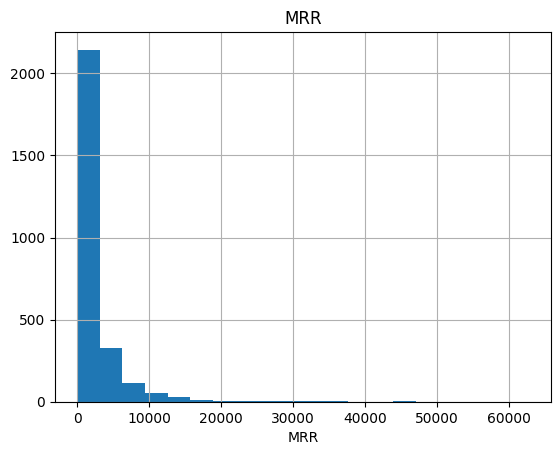

In [33]:
num_summary(merged_df,"MRR",plot=True)

# Korelasyon Analizi 

`MRR`: MRR ile 'Help Ticket Count' arasında orta düzeyde pozitif bir ilişki var. Yani, MRR arttıkça yardım bilet sayısı da artıyor. Bu, daha yüksek gelir getiren müşterilerin genellikle daha fazla destek talebinde bulunduğunu gösteriyor. `Total Revenue`  ile `MRR`arasında zayıf bir pozitif ilişki mevcut. Bu, toplam gelirdeki değişimlerin MRR üzerinde çok fazla etkisi olmadığını gösteriyor.
`Help Ticket Lead Time` ise MRR arasında zayıf bir ilişki var. Yani MRR arttıkça çözüm süresi üzerinde belirgin bir etkisi gözlemlenmiyor.

`Total Revenue`: ile 'Help Ticket Count' arasında zayıf bir ilişki var. Bu, toplam gelirin artmasının yardım bilet sayısını çok fazla etkilemediğini gösteriyor. `Total Revenue` ile yardım çözüm süresi arasında dikkate değer bir ilişki yok.

`Help Ticket Count`: ile `Help Ticket Lead Time` arasında orta düzeyde pozitif bir ilişki var. Yani, daha fazla yardım bileti geldiğinde çözüm süresi de artıyor. Bu, iş yükünün arttıkça daha uzun süreli yanıtlar gerektirdiğini gösteriyor.


In [34]:
num_cols = [col for col in merged_df.columns if merged_df[col].dtype in [int, float]]

corr = merged_df[num_cols].corr()
corr

,MRR,Total Revenue,Help Ticket Count,Help Ticket Lead Time (hours)
MRR,1.00,0.17,0.41,0.12
Total Revenue,0.17,1.00,0.15,0.04
Help Ticket Count,0.41,0.15,1.00,0.26
Help Ticket Lead Time (hours),0.12,0.04,0.26,1.00


In [35]:
corr["MRR"].sort_values(ascending=False)

MRR                             1.00
Help Ticket Count               0.41
Total Revenue                   0.17
Help Ticket Lead Time (hours)   0.12
Name: MRR, dtype: float64

In [36]:
corr["Total Revenue"].sort_values(ascending=False)

Total Revenue                   1.00
MRR                             0.17
Help Ticket Count               0.15
Help Ticket Lead Time (hours)   0.04
Name: Total Revenue, dtype: float64

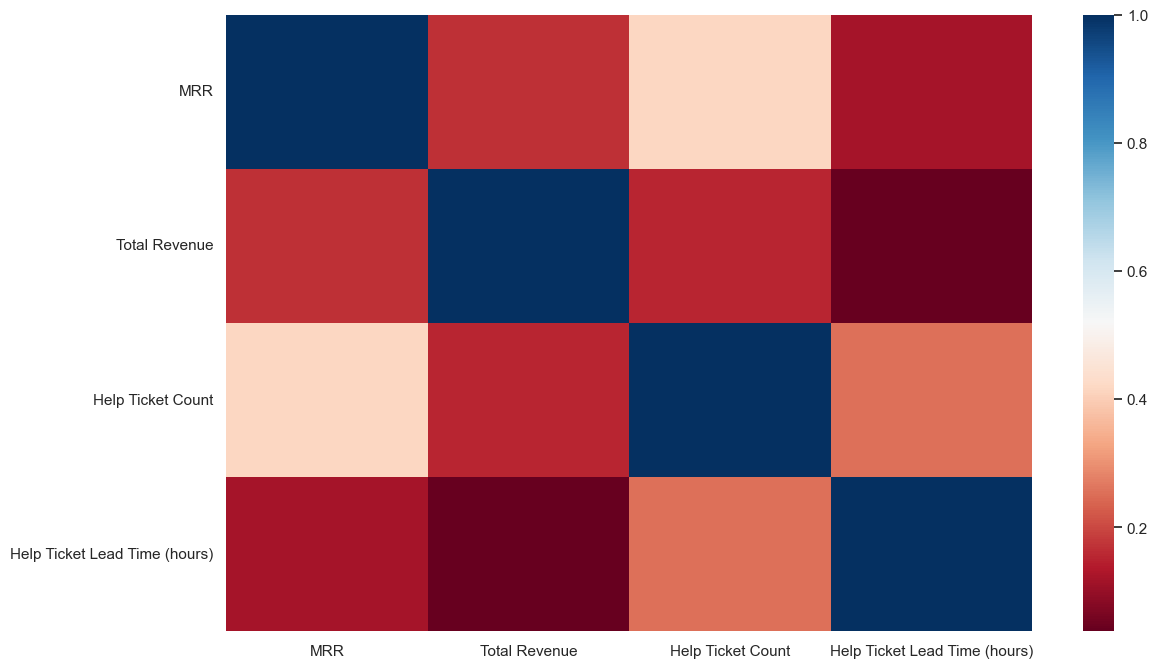

In [37]:
num_cols = [col for col in merged_df.columns if merged_df[col].dtype in [int, float]]

corr = merged_df[num_cols].corr()

sns.set(rc={'figure.figsize': (13, 8)})
sns.heatmap(corr, cmap="RdBu")
plt.show()


In [38]:
# Customer_Age ile MRR ve diğer değişkenler arasındaki ilişki

In [39]:
Customer_Age.head()

,CRM ID,Customer Age (Months)
0,CRM-1471650,24
1,CRM-1516050,13
2,CRM-1087300,25
3,CRM-1467150,12
4,CRM-230550,12


In [40]:
Customer_Age["CRM ID"]=Customer_Age["CRM ID"].str.replace('CRM-','')
Customer_Age.rename(columns={"CRM ID":"ID"},inplace=True)

In [41]:
Customer_Age.head()

,ID,Customer Age (Months)
0,1471650,24
1,1516050,13
2,1087300,25
3,1467150,12
4,230550,12


In [42]:
df_age=merged_df.merge(Customer_Age,on="ID",how='inner')
df_age.head()

,ID,MRR,Total Revenue,Help Ticket Count,Help Ticket Lead Time (hours),Status,Customer Level,Region,Vertical,Subvertical,Customer Age (Months)
0,1002400,"6,716.00","279,868.00",55.00,701.00,Retained,Enterprise,CEE,Retail,Cosmetics,39
1,1005900,"29,012.00","2,690,946.00",4.00,"2,709.00",Retained,Enterprise,Korea,Retail,Consumer Electronics,36
2,1006000,"3,257.00",0.00,1.00,"1,789.00",Retained,Semi-Enterprise,Korea,Retail,Cosmetics,38
3,1010150,679.00,"12,272.00",5.00,785.00,Retained,Long-tail,Australia,Retail,Cosmetics,38
4,1011600,0.00,0.00,0.00,0.00,Churn,Long-tail,Turkey,Other,Other,11


In [43]:
num_cols = [col for col in df_age.columns if df_age[col].dtype in [int, float]]

corr = df_age[num_cols].corr()
corr

,MRR,Total Revenue,Help Ticket Count,Help Ticket Lead Time (hours),Customer Age (Months)
MRR,1.00,0.17,0.42,0.13,0.12
Total Revenue,0.17,1.00,0.15,0.04,0.07
Help Ticket Count,0.42,0.15,1.00,0.25,0.31
Help Ticket Lead Time (hours),0.13,0.04,0.25,1.00,0.27
Customer Age (Months),0.12,0.07,0.31,0.27,1.00


`Müşteri yaşı (Customer Age)`: Müşteri yaşı, MRR üzerinde sınırlı bir etkiye sahip gibi görünmektedir. Daha yüksek bir müşteri yaşı, MRR'da artışa neden olabilir, ancak bu ilişki oldukça zayıf olduğundan sadece müşteri yaşına bağlı olarak MRR'ı artırmak mümkün değildir. 

**EXTRA!**
Daha uzun süre hizmet alan müşteriler, genellikle daha fazla değer üretebilir. Bu müşteri grubuyla ilişkilerin güçlendirilmesi, uzun vadede geliri artırabilir.

In [44]:
corr["MRR"].sort_values(ascending=False)

MRR                             1.00
Help Ticket Count               0.42
Total Revenue                   0.17
Help Ticket Lead Time (hours)   0.13
Customer Age (Months)           0.12
Name: MRR, dtype: float64

In [45]:
df_age.head()

,ID,MRR,Total Revenue,Help Ticket Count,Help Ticket Lead Time (hours),Status,Customer Level,Region,Vertical,Subvertical,Customer Age (Months)
0,1002400,"6,716.00","279,868.00",55.00,701.00,Retained,Enterprise,CEE,Retail,Cosmetics,39
1,1005900,"29,012.00","2,690,946.00",4.00,"2,709.00",Retained,Enterprise,Korea,Retail,Consumer Electronics,36
2,1006000,"3,257.00",0.00,1.00,"1,789.00",Retained,Semi-Enterprise,Korea,Retail,Cosmetics,38
3,1010150,679.00,"12,272.00",5.00,785.00,Retained,Long-tail,Australia,Retail,Cosmetics,38
4,1011600,0.00,0.00,0.00,0.00,Churn,Long-tail,Turkey,Other,Other,11


In [46]:
Chrun_age = df_age.loc[df_age["Status"]=="Churn"].reset_index(drop=True)

In [47]:
Chrun_age.head()

,ID,MRR,Total Revenue,Help Ticket Count,Help Ticket Lead Time (hours),Status,Customer Level,Region,Vertical,Subvertical,Customer Age (Months)
0,1011600,0.00,0.00,0.00,0.00,Churn,Long-tail,Turkey,Other,Other,11
1,1023900,0.00,0.00,0.00,0.00,Churn,Long-tail,Turkey,Travel,Online Travel Agency (OTA),3
2,1029150,0.00,0.00,0.00,0.00,Churn,Semi-Enterprise,Vietnam,Classifieds,Classifieds,24
3,1031550,0.00,0.00,0.00,0.00,Churn,Long-tail,Russia,Travel,Online Travel Agency (OTA),18
4,1032050,0.00,0.00,13.00,248.00,Churn,Long-tail,MENA,Restaurants and Delivery,Restaurants and Delivery,6


`Customer Age (Months)` ile `Churn` olan müşterileri incelediğimizde ise en fazla `Turkey` yaşların toplamına sahip yukarda da teyit ettiğimiz gibi en fazla `Help Ticket Lead Time (hours)` olmasıda şaşırtıcı değil.

In [48]:
Chrun_age.groupby("Region")[["MRR","Total Revenue","Help Ticket Count","Help Ticket Lead Time (hours)","Customer Age (Months)"]].\
    agg({"mean","sum"}).\
    sort_values(("Customer Age (Months)","sum"),ascending=False)

MRR           Total Revenue      Help Ticket Count          Help Ticket Lead Time (hours)            Customer Age (Months)      
                   mean       sum          mean  sum              mean      sum                          mean        sum                  mean   sum
Region                                                                                                                                              
Turkey            32.40 11,535.00          0.00 0.00              3.66 1,304.00                        324.19 115,411.00                 17.58  6260
CEE                0.00      0.00          0.00 0.00              2.39   328.00                        373.79  51,209.00                 20.85  2857
MENA              58.46  5,495.00          0.00 0.00              2.44   229.00                        260.69  24,505.00                 17.41  1637
Russia            40.14  3,051.00          0.00 0.00              1.57   119.00                        352.72  26,807.00                 18.07  1373
Vietnam          486.73 36,505.00          0.00 0.00              1.45   109.00                        129.93   9,745.00                 16.85  1264
Indonesia        139.22 10,024.00          0.00 0.00              0.44    32.00                        160.04  11,523.00                 17.33  1248
Taiwan           648.88 44,124.00          0.00 0.00              3.65   248.00                        237.90  16,177.00                 16.93  1151
Singapore          0.00      0.00          0.00 0.00              4.51   185.00                        287.73  11,797.00                 17.63   723
Australia        704.24 26,057.00          0.00 0.00              6.68   247.00                        177.86   6,581.00                 17.54   649
Malaysia         184.09  6,075.00          0.00 0.00              9.24   305.00                        482.00  15,906.00                 18.58   613
United Kingdom     0.00      0.00          0.00 0.00              2.97   113.00                        142.58   5,418.00                 15.76   599
Korea            177.49  7,277.00          0.00 0.00              0.05     2.00                         27.39   1,123.00                 12.71   521
Thailand           0.00      0.00          0.00 0.00              2.97    86.00                        235.10   6,818.00                 16.79   487
Japan              0.00      0.00          0.00 0.00              0.00     0.00                          0.00       0.00                 16.35   376
Spain              0.00      0.00          0.00 0.00              3.72    67.00                        279.72   5,035.00                 11.44   206
France             0.00      0.00          0.00 0.00              3.24    68.00                        173.48   3,643.00                  8.71   183
Hong Kong      1,156.33 13,876.00          0.00 0.00              7.42    89.00                        610.33   7,324.00                 15.17   182
Philippines        0.00      0.00          0.00 0.00              0.33     4.00                         22.67     272.00                 10.42   125
Benelux            0.00      0.00          0.00 0.00              9.75   117.00                        413.33   4,960.00                  8.75   105
Brazil             0.00      0.00          0.00 0.00             16.40    82.00                        432.40   2,162.00                 15.40    77
United States    214.29  1,500.00          0.00 0.00             13.71    96.00                        600.71   4,205.00                 11.00    77
South Cone     1,000.00  4,000.00          0.00 0.00              6.50    26.00                        522.25   2,089.00                 12.75    51
Mexico             0.00      0.00          0.00 0.00              1.25     5.00                        319.25   1,277.00                  2.75    11

# Genel Öneriler

- Yüksek MRR’li(Retail gibi) sektörlerde çapraz satış ve müşteri sadakati programlarına yatırım yapılabilir.
- Yüksek destek talebine sahip sektörlerde otomasyon, self-servis çözümleri ve chatbot uygulamaları ile müşteri desteği maliyetleri azaltılabilir.
- Düşük MRR’li sektörlerde (B2B SaaS, Comparison) yeni fiyatlandırma stratejileri geliştirilebilir.

`Bu içgörüler, E-Corp’un stratejik karar alma süreçlerine katkı sağlayacaktır.`

# SON